<img src="images/JHI_STRAP_Web.png" style="width: 150px; float: right;">

# Supplementary Information: Holmes *et al.* 2017

# 4. *etpD* knockouts and complementation

This notebook describes raw data import, cleaning and QA, then modelling of the *etpD* knockout and complementation experiments.

## Table of Contents

 1. [Experiment design](#design)
 2. [Data import](#import_data)
    1. [Problematic probes](#problem_probes)
    2. [Interpolation for problematic probes](#interpolation)   
 3. [Model definition](#definition)
 4. [Wide to long form](#wide_to_long)
 5. [Probe matches to Sakai and DH10B](#probe_matches)
 6. [Write data](#write)

## Python imports

In [1]:
%pylab inline

import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## 1. Experiment design <a id="design"></a>

The experiments comprise four variants of *E. coli* Sakai:

1. Wild Type (`WT`)
2. *etpD* knockouts: ΔetpD (`KO`)
3. empty plasmid pSE380: (`empty`)
4. plasmid pSE380 carrying *etpD* complement: (`complement`)

These four variants are each and separately exposed to two spinach plant tissues: *leaf* and *root*, and logCFU determined as a proxy for adherence, as described in the manuscript.

The questions at hand are:

1. Is there a difference in logCFU for `KO` with respect to `WT`? If so, what is the direction and magnitude of change?
2. Is there a difference in logCFU for `complement` with respect to `empty`? If so, what is the direction and magnitude of change?

For each tissue, the experiments were conducted such that each logCFU measurement was acquired on a single, independent plant or leaf. This means that there is **no natural pairing of specific `WT` and `KO`, or `empty` and `complement` measurements**. The natural comparison is within-batch, and pooled.

Measurements were made in batches of five. That is, on a particular half-day a batch of ten measurements were made: five `KO` and five `WT`; or five `empty` and five `complement`. There is therefore **no natural pairing of `WT`/`KO` to `empty`/`complement` measurements** as these were carried out in different batches at different times. We may assume that each batch is subject to specific effects that may bias the observed logCFU with respect to other batches.

## 2. Data import <a id="import_data"></a>

<div class="alert alert-warning">
Raw data was previously converted to plain text comma-separated variable format from the `Excel` files `etpD_raw_data.xlsx`:

<ul>
<li> The file `leaves.csv` contains data from experiments on spinach leaves
<li> The file `roots.csv` contains data from experiments on spinach roots
</ul>
</div>

We import the data using `pandas`:

In [2]:
# Raw data locations
leafdatafile = "../data/etpD/leaves.csv"
rootdatafile = "../data/etpD/roots.csv"

# Parse data
leafdata = pd.read_csv(leafdatafile)
rootdata = pd.read_csv(rootdatafile)

In [3]:
# Show leaf data
leafdata.head()

,Sakai,delta EtpD,pSE380,pSE_EtpD
0,1.496078e+06,424092.4092,7.414966e+05,3288288.288
1,9.719888e+05,122362.8692,2.788462e+06,4272300.469
2,1.614790e+06,451790.6336,4.020619e+05,2897435.897
3,6.333333e+05,894444.4444,4.341564e+05,2933333.333
4,1.228175e+06,676767.6768,7.233010e+05,1450396.825


In [4]:
# Show root data
rootdata.head()

,Sakai,delta EtpD,pSE380,pSE_EtpD
0,4750000.000,852564.1026,439814.8148,662162.1622
1,2000000.000,666666.6667,588652.4823,569230.7692
2,2166666.667,757894.7368,699530.5164,154166.6667
3,4927536.232,618618.6186,682051.2821,565040.6504
4,5714285.714,973856.2092,628415.3005,307692.3077


### Process data

The raw data are, as described above, divisible into batches of five as separate (`Sakai`/`WT`; `delta EtpD`/`KO`) and (`pSE380`/`empty`; `pSE_EtpD`/`complement`) results. We need to convert the data from wide to long form, introduce four categorical factors to describe the states `KO`, `pSE380`, `etpD` (complement), and introduce a further batch identifier, in blocks of five rows.

In [5]:
def wide_to_long(df):
    """Convert wide form array to long form array.
    
    Assumes the columns are in order: Sakai, delta EtpD, pSE380,
    pSE_EtpD.
    
    Splits the data into two tables: Sakai and delta Etpd;
    pSE380 and pSE_EtpD. Adds a column `batch` and fills this
    incrementally in groups of five, *not* repeating batch
    number across the two tables.
    
    Then the tables are melted with all data values in a single
    column headed CFU, and the batch column retained. The tables
    are joined row-wide (Sakai/EtpD table on top).
    
    New columns are added: KO, pSE380, etpD. These columns are
    filled as 1/0 depending on the originating column for the
    value:
    
    - first 25% of rows are 0, 0, 0
    - next 25% of rows are 1, 0, 0
    - next 25% of rows are 1, 1, 0
    - next 25% of rows are 1, 1, 1
    """
    # Split data
    df1 = df[['Sakai', 'delta EtpD']]
    df2 = df[['pSE380', 'pSE_EtpD']]
    
    # Assign batches
    for idx, dfn in enumerate([df1, df2]):
        dfn['batch'] = (floor(array(dfn.index)/5) + 1).astype(int)
        dfn['batch'] = (dfn['batch'] + (len(dfn)/5 * idx)).astype(int)

    # wide to long
    df1 = pd.melt(df1, id_vars=['batch'], value_vars=['Sakai', 'delta EtpD'])
    df2 = pd.melt(df2, id_vars=['batch'], value_vars=['pSE380', 'pSE_EtpD'])
 
    # Concatenate dataframes lengthwise and rename headers
    df = pd.concat([df1, df2])
    df.columns = ['batch', 'label', 'CFU']
    
    # Add factors
    df['KO'] = [0] * int(0.25 * len(df)) + [1] * int(0.75 * len(df))
    df['empty'] = [0] * int(0.5 * len(df)) + [1] * int(0.5 * len(df))    
    df['complement'] = [0] * int(0.75 * len(df)) + [1] * int(0.25 * len(df))
    
    # Convert values to log_10 values
    df['logCFU'] = log10(df['CFU'])
    
    # Make factors categorical
    for col in ['batch', 'KO', 'empty', 'complement', 'label']:
        df[col] = df[col].astype('category')
    
    return df

In [6]:
# Convert data from wide to long
leafdata = wide_to_long(leafdata)
rootdata = wide_to_long(rootdata)

In [7]:
# Show leaf data
leafdata.head()

,batch,label,CFU,KO,empty,complement,logCFU
0,1,Sakai,1.496078e+06,0,0,0,6.174954
1,1,Sakai,9.719888e+05,0,0,0,5.987661
2,1,Sakai,1.614790e+06,0,0,0,6.208116
3,1,Sakai,6.333333e+05,0,0,0,5.801632
4,1,Sakai,1.228175e+06,0,0,0,6.089260


In [8]:
# Show root data
rootdata.head()

,batch,label,CFU,KO,empty,complement,logCFU
0,1,Sakai,4750000.000,0,0,0,6.676694
1,1,Sakai,2000000.000,0,0,0,6.301030
2,1,Sakai,2166666.667,0,0,0,6.335792
3,1,Sakai,4927536.232,0,0,0,6.692630
4,1,Sakai,5714285.714,0,0,0,6.756962


### Inspect data

We can visualise the data for root and leaf applications to see trends, such as whether there are batch effects that need to be considered:

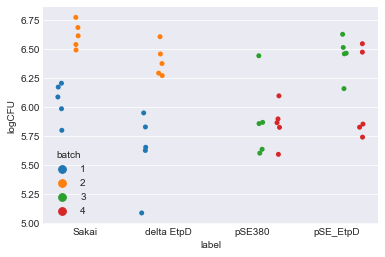

In [9]:
# Plot leaf data by treatment, split by batch
ax = sns.stripplot(x='label', y='logCFU', hue='batch',
                   data=leafdata,
                   jitter=True, dodge=True)

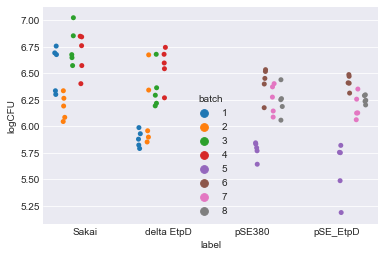

In [10]:
# Plot root data by treatment, split by batch
ax = sns.stripplot(x='label', y='logCFU', hue='batch',
                   data=rootdata,
                   jitter=True, dodge=True)

From these plots we can see that there appear to be strong batch effects for both sets of experiments.

1. In the leaf data, batch 1 (`WT`/`KO`) seems to give lower logCFU readings than batch 2 (`WT`/`KO`).
2. For the root data, batches 1 and 2 (`WT`/`KO`) seems to give lower logCFU values than batches 3 and 4 (`WT`/`KO`).
3. Also for the root data, batch 5 appears to give lower logCFU values than batches 6-8 (`WT`/`KO`).

This indicates that normalisation of data across batches is required prior to statistical analysis, or that the analysis used should explicitly take into account batch effects.

## 3. Model definition <a id="definition"></a>

We assume that each measurement with index *i* measures the logCFU (proxy for extent of adherence/attachment) of a particular Sakai variant when recovered from plant tissue. We define this measurement as the output $y_{i}$, and assume that it represents the true value of logCFU ($\hat{y_{i}}$) plus some irreducible error in the measurement ($\epsilon$), which is assumed to be the same for all measurements, and normally-distributed with mean 0 and variance $\sigma^{2}_{y}$.

$$y_i = \hat{y_i} + \epsilon_i$$
$$\epsilon_i \sim N(0, \sigma_y^2) \implies y_i \sim N(\hat{y_i}, \sigma_y^2)$$

We assume that the 'true' value $\hat{y_{i}}$ is determined by a combination of factors:

1. The 'inherent' tendency of the `WT` wild-type variant to adhere to the tissue (shared by all datapoints)
2. Modification of (1) by the specific loss of *etpD*
3. Modification of (1) by the presence of plasmid pSE380
4. Modification of (1) by the presence of *etpD* on plasmid pSE380
5. Effects specific to the batch

We treat each of these factors as, essentially, the additive results of categorical effects.

(1) is essentially an intercept, as all observations are of either unmodified or modified WT Sakai, and can be represented as the parameter $\alpha$

(2)-(4) can be coded as `1/0` integer values for a measurement with index $i$ ($t_i$, $u_i$, $v_i$), each with its own parameter ($\beta$, $\gamma$, $\delta$) representing combinations of influences. Splitting the factors in this way enables 'borrowing' of data from the plasmid-bearing variants for the estimate of the effect due to loss of *etpD*. Similarly, it enables the direct estimation of the effect of reintroducing *etpD* as a complement. With this interpretation, the parameters have the meanings:

* $\beta$ - the change in logCFU due to loss of *etpD* with respect to the wild type
* $\gamma$ - the change in logCFU due to incorporation of the pSE380 plasmid. Note that as there is no experiment in which the wild-type Sakai carries this plasmid, this parameter only estimates the effect in a $\Delta etpD$ background.
* $\delta$ - the change in logCFU due to incorporation of *etpD* on the pSE380 plasmid. Note again that this parameter only estimates the effect in a $\Delta etpD$ Sakai background, due to the experiment structure.

(5) Can be represented as an array of parameters, $\phi_{j_{i}}$, where $j \in {1, 2, \ldots, n}$ and $n$ is the number of batches. Each value of $\phi_{j_{i}}$ represents the effect due to batch $j_{i}$ - the batch to which measurement $i$ belongs.

We choose to model each of these parameters as an additive effect acting upon the baseline adherence $\alpha$. Parameters estimated to have negative values diminish adherence; parameters estimated to have positive values enhance adherence. Parameters whose credibility interval span zero will not have been shown to modify baseline adherence.

For each parameter's prior we choose a Cauchy distribution:

$$\alpha \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$

where the variance of each parameter's prior can be drawn from a weak prior. We choose an exponential distribution with mean of unity:

$$\sigma_\alpha \sim \textrm{Exp}(1)$$
$$\sigma_\beta \sim \textrm{Exp}(1)$$
$$\sigma_\gamma \sim \textrm{Exp}(1)$$
$$\sigma_\delta \sim \textrm{Exp}(1)$$

We define batch effects for batch $j_i$ (the batch from which measurement $i$ is drawn) in the same way:

$$j_i \in {1, 2, \ldots, 8}$$
$$\phi_{j_{i}} \sim Cauchy(\mu_{\phi_{j_{i}}}, \sigma_{\phi_{j_{i}}}^2)$$
$$\sigma_{\phi_{j_{i}}} \sim \textrm{Exp}(1)$$

<div class="alert-success">
<b>We therefore construct the following model of the experiment, for a given tissue:</b>

$$y_i = \hat{y_i} + \epsilon_i$$
$$\hat{y_i} = \alpha + \beta t_i + \gamma u_i + \delta v_i + \phi_{j_{i}}$$

$$j_i \in {1, 2, \ldots, 8}$$

$$\alpha \sim Cauchy(\mu_{\alpha}, \sigma_{\alpha}^2)$$
$$\beta \sim Cauchy(\mu_{\beta}, \sigma_{\beta}^2)$$
$$\gamma \sim Cauchy(\mu_{\gamma}, \sigma_{\gamma}^2)$$
$$\delta \sim Cauchy(\mu_{\delta}, \sigma_{\delta}^2)$$
$$\phi_{j_{i}} \sim Cauchy(\mu_{\phi_{j_{i}}}, \sigma_{\phi_{j_{i}}}^2)$$

$$\sigma_\alpha \sim \textrm{Exp}(1)$$
$$\sigma_\beta \sim \textrm{Exp}(1)$$
$$\sigma_\gamma \sim \textrm{Exp}(1)$$
$$\sigma_\delta \sim \textrm{Exp}(1)$$
$$\sigma_{\phi_{j_{i}}} \sim \textrm{Exp}(1)$$

<ul>
<li> $y_i$: measured logCFU for a single application $i$ of bacteria to a plant
<li> $\hat{y_i}$: 'true' logCFU for a single application $i$ of bacteria to a plant
<li> $\epsilon_i$: measurement error in logCFU for a single application of $i$ of bacteria to a plant
<li> $\alpha$: the expected logCFU for wild-type (`WT`) Sakai to a plant
<li> $\mu_\alpha$: mean logCFU for `WT` Sakai on the plant
<li> $\sigma_\alpha$: variance logCFU for `WT` Sakai on the plant
<li> $\beta$: the expected modification of logCFU w.r.t. `WT` as the result of deletion of *etpD*
<li> $\mu_\beta$: mean change in logCFU for `KO` w.r.t. `WT` Sakai on the plant
<li> $\sigma_\alpha$: variance for change in logCFU for `KO` w.r.t. `WT` Sakai on the plant
<li> $t_i$: 0/1 pseudovariable indicating whether the strain used for $i$ is $\Delta etpD$ (is `KO`)
<li> $\gamma$: the expected modification of logCFU w.r.t. `KO` as the result of incorporation of plasmid pSE380
<li> $\mu_\gamma$: mean change in logCFU for `empty` w.r.t. `KO` Sakai on the plant
<li> $\sigma_\gamma$: variance for change in logCFU for `empty` w.r.t. `KO` Sakai on the plant
<li> $u_i$: 0/1 pseudovariable indicating whether the strain used for $i$ is $\Delta etpD$ and carrying pSE380 (is `empty`)
<li> $\delta$: the expected modification of logCFU w.r.t. `empty` as the result of complementation with *etpD*
<li> $\mu_\delta$: mean change in logCFU for `complement` w.r.t. `empty` Sakai on the plant
<li> $\sigma_\delta$: variance for change in logCFU for `complement` w.r.t. `empty` Sakai on the plant
<li> $v_i$: 0/1 pseudovariable indicating whether the strain used for $i$ is $\Delta etpD$, carrying pSE380, and includes the complemented *etpD* (is `complement`)
<li> $j_i$: the batch from which $i$ is drawn, $j \in {1, 2, \ldots, 8}$
<li> $\phi_{j_{i}}$: the expected modification of logCFU for batch $j_i$ w.r.t. `WT`
<li> $\mu_{\phi_{j_{i}}}$: mean change in logCFU for batch $j_i$ w.r.t. `WT`
<li> $\sigma_{\phi_{j_{i}}}$: variance for change in logCFU for batch $j_i$ w.r.t. `WT`
</div>